In [2]:
import os
import time
from collections import OrderedDict
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.transforms.functional import to_tensor

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

from nltk.tokenize import word_tokenize, RegexpTokenizer

import wandb


# set WANDB_NOTEBOOK_NAME 
os.environ['WANDB_NOTEBOOK_NAME'] = 'mc2.ipynb'


In [46]:
config = dict(
    epochs=150,
    batch_size=128,
    learning_rate=0.001,
    accelerator='gpu' if torch.cuda.is_available() else None,
    image_dir = 'flickr8k/images',
    caption_file = 'flickr8k/captions.txt',
    embedding_dim = 512,
    lstm_layers = 1,
    max_caption_length = 40,
    debug = False,
)

config

{'epochs': 150,
 'batch_size': 128,
 'learning_rate': 0.001,
 'accelerator': 'gpu',
 'image_dir': 'flickr8k/images',
 'caption_file': 'flickr8k/captions.txt',
 'embedding_dim': 512,
 'lstm_layers': 1,
 'max_caption_length': 40,
 'debug': False}

In [47]:
class Vocab():

    def __init__(self, captions_file, tokenizer):
        self.tokenizer = tokenizer
        self.captions_file = captions_file
        self.build_vocab()

    def build_vocab(self):
        vocab = OrderedDict()

        # Add special tokens
        vocab['<pad>'] = None
        vocab['<sos>'] = None
        vocab['<eos>'] = None
        vocab['<unk>'] = None

        captions = pd.read_csv(config["caption_file"], delimiter='|')['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', ' ', regex=True)
        if config["debug"]:
            captions = captions[:500:5]
        
        token_freq = {}
        for caption in captions:
            for token in self.tokenizer(caption):
                if token not in token_freq:
                    token_freq[token] = 1
                else:
                    token_freq[token] += 1

        for token, freq in token_freq.items():
            if freq >= 3:
                vocab[token] = None


        self.idx2word = list(vocab.keys())
        self.word2idx = {word: idx for idx, word in enumerate(self.idx2word)}

        self.pad_idx = self.word2idx['<pad>']
        self.sos_idx = self.word2idx['<sos>']
        self.eos_idx = self.word2idx['<eos>']

    def __len__(self):
        return len(self.idx2word)

    def token_to_idx(self, token):
        if token not in self.word2idx:
            return self.word2idx['<unk>']
        else:
            return self.word2idx[token]

    def idx_to_token(self, idx):
        return self.idx2word[idx]


special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens

vocab = Vocab(config["caption_file"], tokenizer=special_word_tokenizer.tokenize)

print(f'Vocab size: {len(vocab)}, Pad index: {vocab.pad_idx}, SOS index: {vocab.sos_idx}, EOS index: {vocab.eos_idx}')

Vocab size: 4097, Pad index: 0, SOS index: 1, EOS index: 2


In [52]:
# debug vocab
test_string = 'a brown dog is running on the grass, like florin!'
print(f'Original string: {test_string}')
tokenized_string = special_word_tokenizer.tokenize(test_string)
print(f'Tokenized string: {tokenized_string}')
tokenized_string_idx = [vocab.token_to_idx(token) for token in tokenized_string]
print(f'Tokenized string indices: {tokenized_string_idx}')
converted_string = [vocab.idx_to_token(idx) for idx in tokenized_string_idx]
print(f'Converted string: {converted_string}')

Original string: a brown dog is running on the grass, like florin!
Tokenized string: ['a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', 'like', 'florin']
Tokenized string indices: [4, 42, 29, 9, 114, 39, 24, 66, 1160, 3]
Converted string: ['a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', 'like', '<unk>']


In [59]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, tokenizer, vocab, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the txt file with captions.
            transform (callable, optional): Optional transform to be applied
                on a image sample.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, delimiter='|')
        if config["debug"]:
            # select only the first 10 images for testing
            self.df = self.df[:500:5]
        self.transform = transform
        self.tokenizer = tokenizer
        self.vocab = vocab

        # clean caption_text
        self.df['caption_text'] = self.df['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', " ", regex=True)
        # append <start> and <end> to caption_text
        self.df['caption_text'] = self.df['caption_text'].apply(lambda x: '<sos> ' + x + ' <eos>') \
                                                         .apply(lambda x: torch.LongTensor(self._caption_to_idx(x)))
        # store memory
        self.captions_image_names = list(zip(self.df['caption_text'], self.df['image_name']))
        
        self.images = {}

        # load all images into memory
        for img_name in tqdm(self.df['image_name'].unique()):
            img_path = os.path.join(self.root_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)

            self.images[img_name] = image

    def _caption_to_idx(self, caption):
        return [self.vocab.token_to_idx(word) for word in self.tokenizer(caption)]
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption, img_name = self.captions_image_names[idx]
        image = self.images[img_name].clone()
        return image, caption

In [54]:
dataset = Flickr8kDataset(config["image_dir"],
                          config["caption_file"],
                          special_word_tokenizer.tokenize,
                          vocab,
                          models.ResNet50_Weights.IMAGENET1K_V1.transforms())
print(len(dataset))

100%|██████████| 8091/8091 [01:06<00:00, 121.85it/s]

40455


In [7]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        images, captions = zip(*batch)
        images = torch.stack(images)
        captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


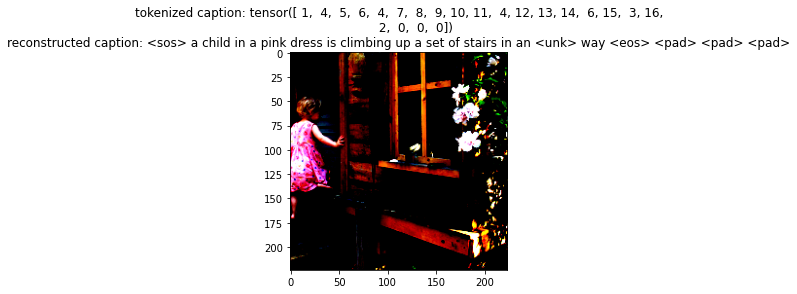

In [55]:
test_loader = DataLoader(dataset,
                         batch_size=config["batch_size"],
                         shuffle=False,
                         pin_memory=True,
                         collate_fn=Collate(vocab.pad_idx))
for i, (images, captions) in enumerate(test_loader):
    token_caption = captions[0]
    reconstructed_caption = [vocab.idx_to_token(idx) for idx in token_caption]
    plt.imshow(images[0].permute(1, 2, 0))
    plt.title(f"tokenized caption: {token_caption}\nreconstructed caption: {' '.join(reconstructed_caption)}")
    plt.show()
    break

In [17]:
# analyze the captions lengths
lengths = []
total_data_loader_len = len(test_loader)
for i, (images, captions) in tqdm(enumerate(test_loader), total=total_data_loader_len):
    lengths.append(np.array(captions.shape[1] - (captions == vocab.pad_idx).sum(dim=1)))

100%|██████████| 1265/1265 [00:13<00:00, 95.38it/s]


In [18]:
# convert lengths to numpy array
np.concatenate(lengths).shape

(40455,)

Captions lengths shape: (40455,)


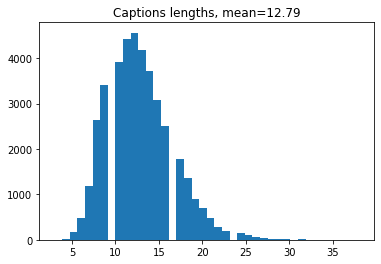

In [19]:
lengths_arr = np.concatenate(lengths)

print("Captions lengths shape:", lengths_arr.shape)

plt.hist(lengths_arr, bins=40)
plt.title("Captions lengths, mean={:.2f}".format(lengths_arr.mean()))
plt.show()


# Model

In [92]:
class ImageCaptioning(pl.LightningModule):

    def __init__(self, embedding_dim: int, lstm_layers: int, vocabulary_size: int, padding_idx: int, learning_rate: float):
        super(ImageCaptioning, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Sequential(*list(models.resnet50(weights=models.ResNet50_Weights.DEFAULT).children())[:-1]),
            nn.Flatten(),
            nn.Linear(models.resnet50().fc.in_features, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        for param in self.encoder[0].parameters():
            param.requires_grad_(False)

        # Decoder
        self.decoder = nn.ModuleDict({
            'embedding_layer': nn.Embedding(vocabulary_size, embedding_dim),
            'lstm': nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, num_layers=lstm_layers, dropout = 0.5),
            'inv_embedding': nn.Sequential(nn.Linear(embedding_dim, vocabulary_size), nn.LogSoftmax(dim=2))
        })
        
        self.learning_rate = learning_rate

        # Initialize weights
        self.init_weights()
        
        self.save_hyperparameters()


    def init_weights(self):
        # Initialize the linear layer with the uniform distribution
        nn.init.uniform_(self.encoder[2].weight, -0.1, 0.1)
        nn.init.zeros_(self.encoder[2].bias)
        
        # Initialize the embedding layer with the uniform distribution
        nn.init.uniform_(self.decoder['embedding_layer'].weight, -0.1, 0.1)
        
        nn.init.uniform_(self.decoder['inv_embedding'][0].weight, -0.1, 0.1)
        nn.init.zeros_(self.decoder['inv_embedding'][0].bias)


    def forward(self, images: torch.Tensor, captions: torch.Tensor) -> torch.Tensor:
        # Encoder forward
        # images: (batch_size, channels, pixels, pixels)
        image_embedding = self.encoder(images) # (batch_size, embedding_dim)

        # Decoder forward
        word_embeddings = self.decoder['embedding_layer'](captions).permute(1, 0, 2) # (seq_len, batch_size, embedding_dim)
        
        embeddings = torch.cat((image_embedding.unsqueeze(0), word_embeddings), dim=0)

        outputs, _ = self.decoder['lstm'](embeddings) # (seq_len, batch_size, embedding_dim)
        outputs = self.decoder['inv_embedding'](outputs) # (seq_len, batch_size, vocab_size)
        return outputs


    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.learning_rate, weight_decay=0.0001)

    
    def training_step(self, batch, batch_idx):
        self.train()
        images, captions = batch
        outputs = self(images, captions[:,:-1])
        outputs = outputs[1:] # remove the first word from the output
        captions = captions.permute(1, 0)[1:] # remove the first word from the target
        captions = F.one_hot(captions, num_classes=len(vocab)).float()
        loss = F.nll_loss(outputs.flatten(end_dim=1), captions.flatten(end_dim=1).argmax(dim=1), ignore_index=int(vocab.pad_idx))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        self.eval()
        images, captions = batch
        outputs = self(images, captions[:,:-1])
        outputs = outputs[1:] # remove the first word from the output
        captions = captions.permute(1, 0)[1:] # remove the first word from the target
        # one hot encode the target
        captions = F.one_hot(captions, num_classes=len(vocab)).float()
        loss = F.nll_loss(outputs.flatten(end_dim=1), captions.flatten(end_dim=1).argmax(dim=1), ignore_index=int(vocab.pad_idx))
        self.log('val_loss', loss)
        return loss
    

    def sample(self, images: torch.Tensor, max_length: int = 30):
        self.eval()

        # Encoder forward
        image_embedding = self.encoder(images) # (batch_size, embedding_dim)

        # Initial input for the LSTM cell (start token)
        input_token = torch.tensor([[vocab.sos_idx]], device=images.device)

        output, hidden = self.decoder['lstm'](image_embedding.unsqueeze(0))

        generated_caption = []
        for _ in range(max_length):
            # Embed the input
            input_embed = self.decoder['embedding_layer'](input_token).permute(1, 0, 2)
            
            # LSTM forward
            output, hidden = self.decoder['lstm'](input_embed, hidden)
            output = self.decoder['inv_embedding'](output)
            
            # Get the maximum probable word (greedy decoding)
            predicted_word_idx = output.argmax(dim=2)
            generated_caption.append(predicted_word_idx)

            if predicted_word_idx == vocab.eos_idx:
                break

            input_token = predicted_word_idx

        # Convert the caption into a sequence of words
        generated_caption = torch.cat(generated_caption, dim=0).permute(1, 0).tolist() 
        generated_caption = [[vocab.idx_to_token(idx) for idx in caption] for caption in generated_caption]

        return generated_caption


image_captioning = ImageCaptioning(512, 1, len(vocab), vocab.pad_idx, 0.001).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 

image_captioning.train()

# create random tensor of images and captions 
images = torch.randn(32, 3, 500, 500).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 
# sequence of 40 words
captions = torch.randint(0, len(vocab), (32, 40)).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 
print("captions:", captions.size())

outputs = image_captioning(images, captions[:,:-1])


print("outputs:", outputs.size())

# compute loss
#loss = nn.NLLLoss()(outputs.permute(1, 2, 0), captions.permute(1, 0))
loss = nn.NLLLoss(ignore_index=int(vocab.pad_idx))(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))

print("loss:", loss)

# check if on cuda
print(next(image_captioning.parameters()).is_cuda)
print(next(image_captioning.encoder.parameters()).is_cuda)
print(next(image_captioning.decoder['embedding_layer'].parameters()).is_cuda)
print(next(image_captioning.decoder['lstm'].parameters()).is_cuda)
print(next(image_captioning.decoder['inv_embedding'].parameters()).is_cuda)
print(outputs.is_cuda)

# convert outputs to captions_idx
captions = torch.argmax(outputs, dim=2)
print("captions:", captions.size())

# convert captions_idx to captions
captions = [[vocab.idx_to_token(idx.item()) for idx in caption] for caption in captions]
print("captions:", captions[0])

image = torch.randn(1, 3, 500, 500).to(torch.device('cuda')) 
caption = image_captioning.sample(image)
print("Generated caption:", caption)

c:\Users\flori\miniconda3\envs\del\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


captions: torch.Size([32, 40])
outputs: torch.Size([40, 32, 4097])
loss: tensor(8.3180, device='cuda:0', grad_fn=<NllLossBackward0>)
True
True
True
True
True
True
captions: torch.Size([40, 32])
captions: ['checked', 'conversations', 'grinding', 'appears', 'offering', 'smiling', 'hiker', 'poem', 'juggling', 'trotting', 'sale', 'perched', 'bridal', 'chalk', 'swimmers', 'waits', 'join', '19', 'tussle', 'merchandise', 'crawls', 'stump', 'bit', 'interested', 'alleyway', 'rottweiler', 'mall', 'hummingbird', 'rests', 'gets', 'twilight', 'short']
Generated caption: [['pile', 'pile', 'been', 'song', 'song', 'song', 'balancing', 'jogging', 'song', 'song', 'balancing', 'jogging', 'song', 'balancing', 'jogging', 'song', 'balancing', 'jogging', 'song', 'balancing', 'jogging', 'song', 'balancing', 'jogging', 'song', 'balancing', 'jogging', 'song', 'balancing', 'jogging']]


In [62]:
image_captioning

ImageCaptioning(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
     

In [57]:
# shape (3, 2, 5)
# using integers for simplicity
x = torch.tensor([[[1, 2, 3, 4, 5],
                     [6, 7, 8, 9, 10]],
                    [[11, 12, 13, 14, 15],
                        [16, 17, 18, 19, 20]],
                    [[21, 22, 23, 24, 25],
                        [26, 27, 28, 29, 30]]])
x, x.reshape(-1, x.size(2))

(tensor([[[ 1,  2,  3,  4,  5],
          [ 6,  7,  8,  9, 10]],
 
         [[11, 12, 13, 14, 15],
          [16, 17, 18, 19, 20]],
 
         [[21, 22, 23, 24, 25],
          [26, 27, 28, 29, 30]]]),
 tensor([[ 1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10],
         [11, 12, 13, 14, 15],
         [16, 17, 18, 19, 20],
         [21, 22, 23, 24, 25],
         [26, 27, 28, 29, 30]]))

In [12]:
"""
# visualize the model
from torchviz import make_dot

# print number of parameters
params = list(image_encoder.parameters()) + list(caption_decoder.parameters())
print("Number of parameters:", sum([np.prod(p.size()) for p in params]))

make_dot(outputs, params=dict(list(image_encoder.named_parameters()) + list(caption_decoder.named_parameters()))).render("model", format="png")
"""

Number of parameters: 35711167


'model.png'

In [60]:
class Flickr8kDataModule(pl.LightningDataModule):
    def __init__(self, config, transform=None):
        super().__init__()
        self.config = config
        self.transform = transform
        self.special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens
        self.vocab = Vocab(self.config["caption_file"], tokenizer=self.special_word_tokenizer.tokenize)
        self.config['vocab_size'] = len(self.vocab)
        self.collate_fn = Collate(self.vocab.pad_idx)


    def setup(self, stage=None):
        # check if train_dataset variable exists
        if hasattr(self, 'train_dataset'):
            return
        dataset = Flickr8kDataset(self.config["image_dir"],
                                  self.config["caption_file"],
                                  self.special_word_tokenizer.tokenize,
                                  self.vocab,
                                  self.transform)

        train_split_idx = int(len(dataset) * 0.8)
        val_split_idx = int(len(dataset) * 0.1)
        test_split_idx = len(dataset) - train_split_idx - val_split_idx

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, [train_split_idx, val_split_idx, test_split_idx])


    def dataloader(self, dataset, shuffle=False):
        return DataLoader(dataset,
                          batch_size=self.config["batch_size"],
                          shuffle=shuffle,
                          pin_memory=True,
                          collate_fn=Collate(self.vocab.pad_idx))


    def train_dataloader(self): return self.dataloader(self.train_dataset, shuffle=True)
    def val_dataloader  (self): return self.dataloader(self.val_dataset)
    #def test_dataloader (self): return self.dataloader(self.test_dataset)

flickr8k_data_module = Flickr8kDataModule(config, transform=models.ResNet50_Weights.IMAGENET1K_V1.transforms())

In [20]:
flickr8k_data_module.setup()

100%|██████████| 100/100 [00:00<00:00, 145.69it/s]


In [93]:
# Use the DataModule with a PyTorch Lightning Trainer
wandb.finish()
wandb_logger = WandbLogger(project="del-mc2", entity="florin-barbisch", config=config)

trainer = pl.Trainer(
    accelerator=config["accelerator"],
    max_epochs=config["epochs"],
    logger=wandb_logger,
    log_every_n_steps=1
)

model = ImageCaptioning(
    64,#config["embedding_dim"],
    3,#config["lstm_layers"],
    len(flickr8k_data_module.vocab),
    flickr8k_data_module.vocab.pad_idx,
    0.001#config["learning_rate"]
)

trainer.fit(model, flickr8k_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 23.6 M
1 | decoder | ModuleDict | 628 K 
---------------------------------------
759 K     Trainable params
23.5 M    Non-trainable params
24.3 M    Total params
97.071    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [82]:
# sample on first image and show the result
image, caption = None, None
i = 0
for image, caption in iter(flickr8k_data_module.train_dataloader()):
    if i == 1:
        break
    i += 1
image = image.to(torch.device('cuda'))
image = image[0].unsqueeze(0)
# send image to cuda
#caption = caption[0].unsqueeze(0)

generated_caption = model.sample(image)
print("Generated caption:", generated_caption)

Generated caption: [['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']]
